In [62]:
subj = "Subj3"
exp = "exp1"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = (exp != "reproduction")

### Imports

In [63]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [64]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj3/src/data_rr_filt-raw.fif...
    Range : 3000 ... 654000 =      6.000 ...  1308.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
Features:  (1180, 3)


In [65]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [66]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1180 samples with 3 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [67]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0  133  175  261  458  685  783  938 1037 1126 1180]


100%|██████████| 2016/2016 [00:07<00:00, 282.76it/s]


In [68]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [69]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
36,20,35,10,3,Median,"[0, 260, 735, 1180]",577.68,1.64,0.03,196.03,3.60,0.18,250.70,1.66,0.62,0.39,0.57
52,20,40,20,4,Mode,"[0, 260, 735, 1038, 1180]",363.38,1.30,0.01,135.44,4.37,0.14,161.45,2.93,0.71,0.49,0.63
9,0,40,10,5,Median,"[0, 13, 212, 627, 911, 1180]",209.15,1.35,-0.10,104.97,6.53,0.14,96.47,2.14,0.63,0.42,0.55
4,0,35,15,6,Mode,"[0, 13, 199, 498, 735, 1038, 1180]",165.91,1.14,-0.11,81.43,8.19,0.13,74.18,4.55,0.72,0.56,0.65
0,0,35,10,7,Median,"[0, 13, 212, 498, 678, 889, 1038, 1180]",119.43,1.15,-0.12,77.48,6.74,0.11,54.64,2.77,0.76,0.60,0.67
40,20,35,15,8,Mode,"[0, 260, 498, 621, 735, 911, 1038, 1109, 1180]",97.17,1.16,-0.10,80.99,6.54,0.12,47.69,2.40,0.78,0.61,0.66
1,0,35,10,9,Mode,"[0, 13, 199, 498, 621, 735, 911, 1038, 1109, 1...",92.01,1.24,-0.14,71.00,9.23,0.12,45.36,2.19,0.75,0.57,0.63
1,0,35,10,10,Mode,"[0, 13, 199, 260, 498, 621, 735, 911, 1038, 11...",60.12,1.11,-0.13,66.62,10.15,0.11,29.18,2.53,0.78,0.64,0.68
4,0,35,15,11,Mode,"[0, 13, 199, 260, 498, 621, 735, 866, 911, 103...",57.10,1.15,-0.14,63.16,7.21,0.12,28.70,2.40,0.78,0.61,0.66
4,0,35,15,12,Mode,"[0, 13, 199, 260, 498, 539, 621, 735, 866, 911...",47.98,1.06,-0.15,57.56,7.67,0.11,24.05,3.02,0.76,0.58,0.63


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,35,10,10,Mode,"[0, 13, 199, 260, 498, 621, 735, 911, 1038, 11...",60.12,1.11,-0.13,66.62,10.15,0.11,29.18,2.53,0.78,0.64,0.68


array([   0,   13,  199,  260,  498,  621,  735,  911, 1038, 1109, 1180])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.25,30.28,1.01,8.35,0.83
1,0.07,23.18,2.43,6.46,0.37
2,0.09,32.70,2.02,10.81,0.47
3,0.07,31.07,2.78,11.06,0.37
4,0.17,68.96,1.56,30.84,0.72
5,0.12,43.60,2.16,18.50,0.52
6,0.05,28.29,2.71,8.38,0.34
7,0.27,86.15,1.29,27.17,0.77
8,0.19,47.44,1.43,17.36,0.70


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 20.5)","(21.5, 223.5)","(224.5, 294.5)","(295.5, 567.5)","(568.5, 700.5)","(702.5, 825.5)","(826.5, 1015.5)","(1017.5, 1154.5)","(1155.5, 1230.5)","(1231.5, 1304.5)"
"Time length, sec",12.0,202.0,70.0,272.0,132.0,123.0,189.0,137.0,75.0,73.0
Number of epochs,13,186,61,238,123,114,176,127,71,71


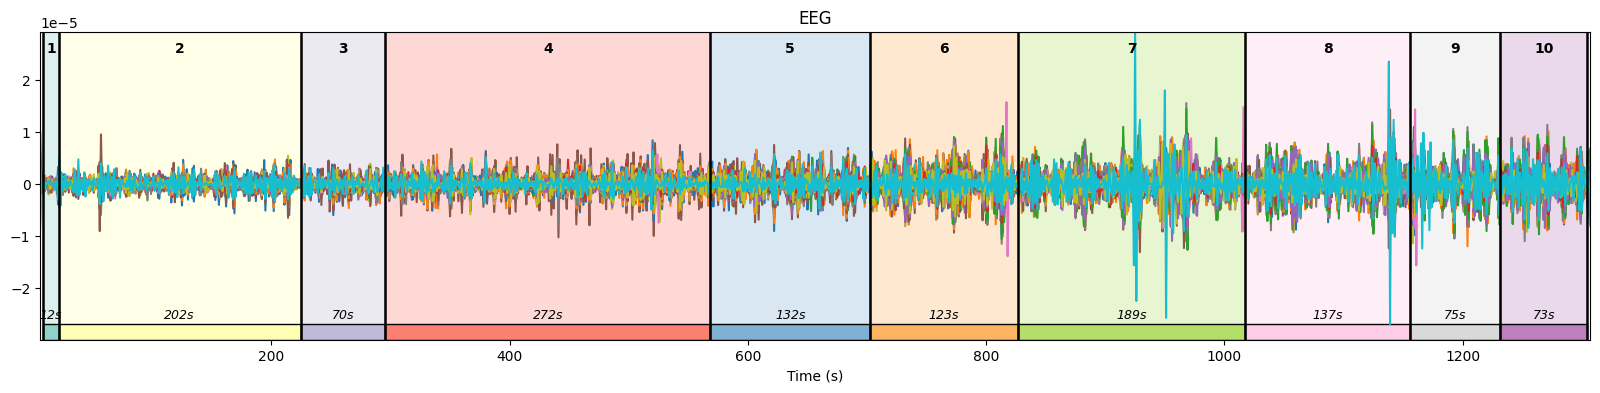

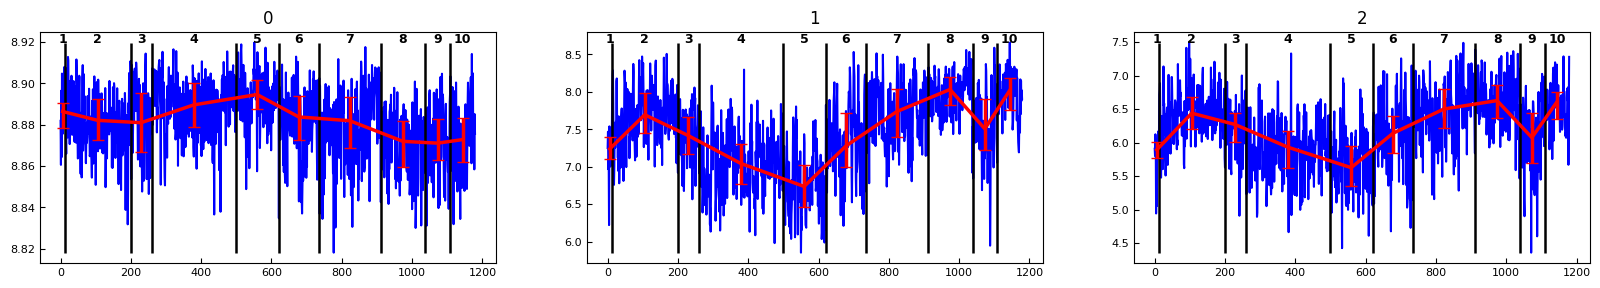

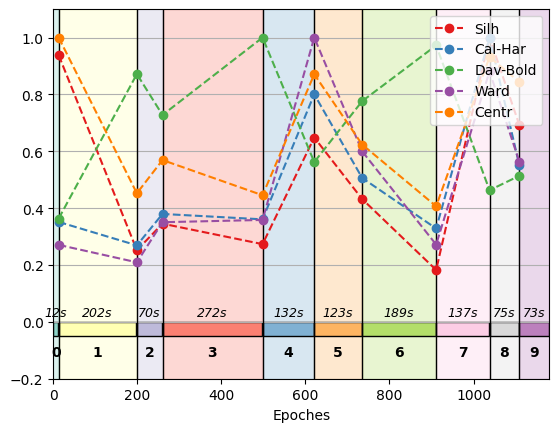

In [70]:
analyze(result, 'Avg-Silh', "internal")

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
93,40,45,15,3,Median,"[0, 260, 764, 1180]",516.93,1.55,0.02,172.35,3.60,0.16,215.18,1.80,0.62,0.39,0.58
52,20,40,20,4,Mode,"[0, 260, 735, 1038, 1180]",363.38,1.30,0.01,135.44,4.37,0.14,161.45,2.93,0.71,0.49,0.63
40,20,35,15,5,Mode,"[0, 260, 498, 735, 1038, 1180]",199.74,0.99,-0.06,101.56,21.58,0.11,88.40,13.73,0.75,0.59,0.67
114,60,35,20,6,Median,"[0, 257, 498, 678, 911, 1038, 1180]",139.81,1.06,-0.09,92.41,9.28,0.09,62.71,3.32,0.79,0.65,0.71
0,0,35,10,7,Median,"[0, 13, 212, 498, 678, 889, 1038, 1180]",119.43,1.15,-0.12,77.48,6.74,0.11,54.64,2.77,0.76,0.60,0.67
72,40,35,10,8,Median,"[0, 199, 260, 498, 623, 735, 911, 1038, 1180]",54.95,0.90,-0.10,75.77,8.13,0.08,25.60,3.08,0.78,0.64,0.69
72,40,35,10,9,Median,"[0, 199, 260, 498, 623, 735, 911, 1038, 1109, ...",61.92,1.03,-0.11,71.57,8.88,0.10,29.37,2.78,0.79,0.65,0.69
78,40,35,20,10,Median,"[0, 87, 199, 260, 498, 623, 735, 911, 1038, 11...",60.27,1.04,-0.12,66.07,9.18,0.10,29.43,2.61,0.79,0.64,0.68
19,0,45,10,11,Mode,"[0, 13, 199, 260, 456, 539, 621, 735, 911, 103...",51.49,1.04,-0.15,60.28,9.98,0.10,24.93,2.80,0.80,0.66,0.70
26,0,45,20,12,Mean,"[0, 21, 199, 261, 452, 522, 617, 724, 861, 910...",41.17,0.97,-0.14,51.95,7.15,0.09,19.93,2.87,0.80,0.64,0.68


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,35,20,10,Median,"[0, 87, 199, 260, 498, 623, 735, 911, 1038, 11...",60.27,1.04,-0.12,66.07,9.18,0.1,29.43,2.61,0.79,0.64,0.68


array([   0,   87,  199,  260,  498,  623,  735,  911, 1038, 1109, 1180])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.10,26.77,2.35,7.50,0.39
1,0.13,40.10,1.74,9.53,0.49
2,0.09,32.70,2.02,10.81,0.47
3,0.07,28.92,2.91,10.39,0.36
4,0.17,65.18,1.61,29.52,0.71
5,0.12,43.40,2.15,18.45,0.52
6,0.05,28.29,2.71,8.38,0.34
7,0.27,86.15,1.29,27.17,0.77
8,0.19,47.44,1.43,17.36,0.70


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 100.5)","(101.5, 223.5)","(224.5, 294.5)","(295.5, 567.5)","(568.5, 703.5)","(704.5, 825.5)","(826.5, 1015.5)","(1017.5, 1154.5)","(1155.5, 1230.5)","(1231.5, 1304.5)"
"Time length, sec",92.0,122.0,70.0,272.0,135.0,121.0,189.0,137.0,75.0,73.0
Number of epochs,87,112,61,238,125,112,176,127,71,71


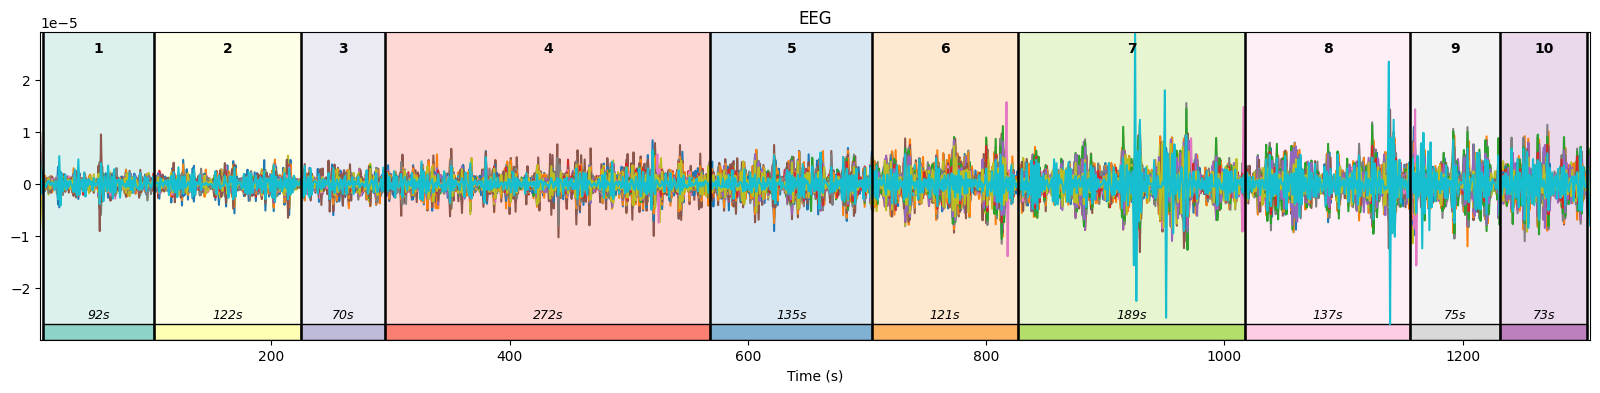

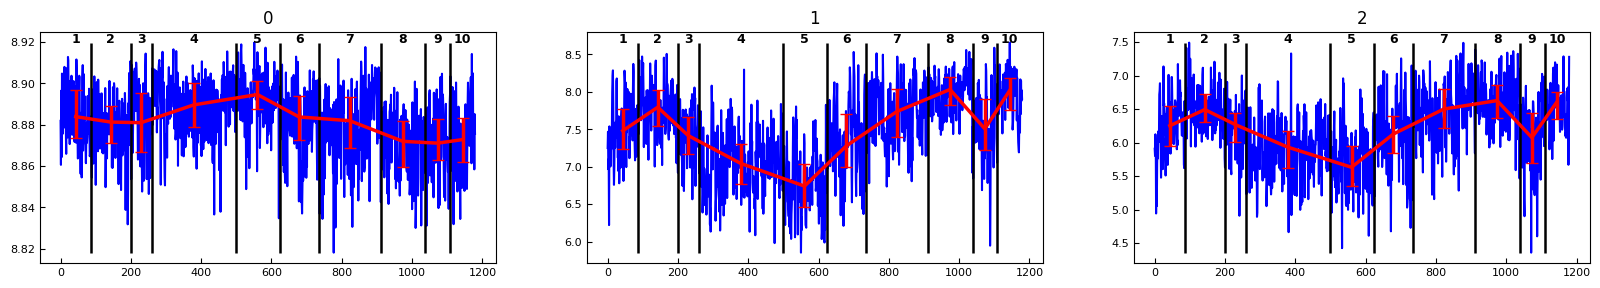

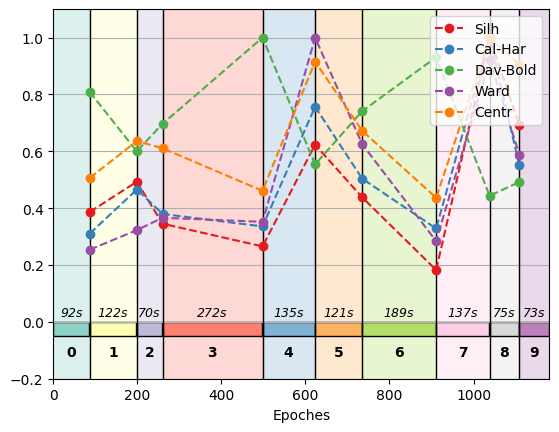

In [71]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")